# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Part I: Environment Setup

All of the hyperparameters we use for creating the network environment:
* `N` is the number of nodes in the graph (including the source and destination nodes)
* `edge_prob` is the probability of an edge occurring between nodes when generating the graph
* `percent_mal` is the percentage of malicious nodes
* `attack_probs` are the bounds for the uniform distribution from which we will draw the attack probability of each malicious node

In [2]:
N = 20      
edge_prob = 0.1 
percent_mal = 0.3
attack_probs = [0.2, 0.8] 

Some helper methods to use when creating the graph:
* `draw_graph` visualizes the graph
* `random_edge` is used to make sure the graph is connected, since the graph is generated randomly and sometimes will not be one single component 

In [3]:
def draw_graph(graph):
    nx.draw(graph, with_labels=True)
    plt.show()

In [4]:
def random_edge(graph):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    chosen_edge = random.choice(edges)
    chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
    
    graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
    
    return graph

Here we create a random graph and add random edges until it is connected, then draw it

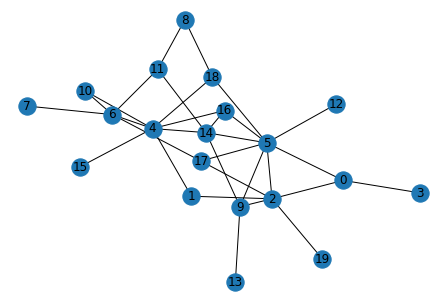

In [5]:
src = 0
dst = N - 1

G = nx.gnp_random_graph(N, edge_prob)

while not nx.is_connected(G):
    G = random_edge(G)

draw_graph(G)

We use the agent class to store information about each node. The agent class is created somewhat lazily, without any actual class definition. We will later define the attributes for each agent.

In [6]:
class agent:
    pass

We randomly assign some percentage (according to `percent_mal`) of the nodes to be malicious. We will assume that the source and destination nodes can't be malicious.

In [17]:
mal_nodes = []

num_mal = int(N * percent_mal)

while (num_mal > 0):
    rand = np.random.randint(0, N)
    
    if rand != 0 and rand != N-1 and rand not in mal_nodes:
        mal_nodes.append(rand)
        num_mal -= 1

For each node in the graph, we create an `agent` class for it. Each agent has the following attributes:
* `node`: The node in the graph that the agent corresponds to 
* `mal`: Whether or not the node is malicious
* `attack_prob`: Random number drawn from a uniform distribution with bounds highlighted in the hyperparameters section; this indicates how likely a malicious node is to "attack"

In [27]:
nodes = list(range(0, N))
agents = []

for node in nodes:
    a = agent()
    a.node = node
    
    if node in mal_nodes:
        a.mal = True
        a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
    else:
        a.mal = False
        a.attack_prob = 0
        
    agents.append(a)

This section provides an example of determining if a path from the source to the destination is corrupted. For each malicious node along the path, a random number is generated and compared to that node's attack probability to see if it will attack the path. The paths are generated using `nx.all_simple_paths()`. This function generates all paths from the source to the destination without doubling back on nodes.
* Note: `nx.all_simple_paths` might take some time to run if the number of nodes is high. 

In [23]:
def if_corrupted(path, verbose=False):
    for node in path: 
        attack_prob = agents[node].attack_prob
        attacked = random.uniform(0,1) < attack_prob
        
        if attacked:
            if verbose:
                print('Path = ', path)
                print('Node %d attacked this path' % node)
            return True
    return False

In [26]:
paths = list(nx.all_simple_paths(G, src, dst))
paths_corruption = []

for path in paths:
    paths_corruption.append(if_corrupted(path))

## Part 2: Reinforcement Learning (RL)

### RL Overview


Reinforcement Learning Algorithm:
Pick a path from the source to the destination (all_simple_paths)
Assign a reward based on how many hops it takes, and if it's corrupted or not (there is a malicious node that is 'attacking' in the path)

0 --> 3* --> 11 --> 19 and 3 attacks during this transmission, we should note that it was a corrupted path

#Over time, our algorithm will go from picking paths at random to picking the paths that are short and unlikely to be corrupted
